# Lab 03: Indexing and Relevance Ranking on Geo-Texts  

In this tutorial, we will experiment on checking/implementing some information retrieval techniques on a geo-text. Most of these techniques like R-tree, TF-IDF, relevance ranking, cosine similarity, etc. have been covered in the lecture. Techniques that you have learnt in Lab 1 and 2 (e.g., geopandas, osm, etc.) will be used/enhanced in this tutoiral. Meanwhile, new techniques such as wordcloud will also be introduced.

A summary of packages you will be using: 
- geopandas 
- pandas
- shapely
- pyrosm (optional)
- [wordcloud](https://pypi.org/project/wordcloud/)
- matplotlib.pyplot
- [numpy](https://numpy.org/)
- [sklearn](https://scikit-learn.org/stable/) 

Okay, now let's discuss first in a very general sense what we want to achieve in this tutorial. The goal is to understand the (functional) characteristics of regions in the City of Bristol. To do it, we use the points of interest and their types (e.g., restaurant, school, police office) as a **proxy** to quantify such a "functional" characteristics. Namely, if a region has a lot of restrants and bars, it might be more likely to be characterized as a food/entertainment region. It is then clearly different from another region where most points of interet are types of, for instance, school and nursery. 

More interestingly, we do not only want to qualitatively describe these regions, we also need a more quantitative method so that computers can also understand it and then retrieve information for us more accurately and effectively. 

## Part 1: Load the local regions (Lower Super Output Areas 2011) for the City of Bristol
First of all, let's load the region data about Bristol. There are many ways to delineate the City (e.g., by administrative office or by local citizens' perception/activity). In this tutorial, we use the data called Lower Super Output Areas 2011. It is created for the collection of census data. "Lower Super Output Areas (LSOAs) are a national geography for collecting, aggregating and reporting statistics. They were designed to improve the reporting of small area statistics and are built up from groups of Output Areas" (https://opendata.bristol.gov.uk/explore/dataset/lsoa110/information/). You can download the data (the csv file) to your local machine using the link as well. The code below then loads the data into Python and convert it to a `geodataframe`. 

Several tips: 
- replace the directory to where your data is downloaded. `../` in my code means going up one level in the directory
- sometimes, we can ignore the parameter `delimiter` in `pd.read_csv` if the delimiter is by default comma. But here, since it is semicolon, we need to indicate it (you can try to see what kind of errors you will encourter if you do not include it)
- the raw data provide geomery information in a geojson format like `{"coordinates": [[[-2.5705649134167503, 51.408...`, to convert it to a format as [well-know text](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry), which is supported by `geopandas`/`shapely`, we write a function `parse_geom` 

In [1]:
import geopandas as gpd
import pandas as pd
import json
from shapely.geometry import shape


def parse_geom(geom_str):
    try:
        return shape(json.loads(geom_str))
    except (TypeError, AttributeError):  # Handle NaN and empty strings
        return None

bristol_lsoal_df = pd.read_csv('../../LabData/Lab3/lsoa110.csv', delimiter=';')
bristol_lsoal_df["geom"] = bristol_lsoal_df["geo_shape"].apply(parse_geom)
bristol_lsoal_gdf = gpd.GeoDataFrame(bristol_lsoal_df, geometry="geom")
print(bristol_lsoal_gdf.head())

   OBJECTID LSOA11 Code   LSOA11 Name LSOA11 Local name MSOA11 Code  \
0         7   E01014612  Bristol 052B    Fortfield East   E02003063   
1         8   E01014512  Bristol 016E   Somerville Road   E02003027   
2        18   E01014618  Bristol 011C    Henleaze North   E02003022   
3        36   E01014576  Bristol 019D        Rose Green   E02003030   
4        24   E01033370  Bristol 054E   Redcliffe South   E02006887   

   Ward code  Area square mteres  Perimeter (m)  MI_PRINX  \
0  E05001989       250084.343750    3010.960449         2   
1  E05001975       178468.437500    3093.555908       152   
2  E05001990       324102.562500    4205.579590       921   
3  E05001984       469484.093750    3586.286133       976   
4  E05001995       126227.867188    2103.395020        19   

                                           geo_shape  \
0  {"coordinates": [[[-2.5705649134167503, 51.408...   
1  {"coordinates": [[[-2.5836634052406393, 51.476...   
2  {"coordinates": [[[-2.6104326165276

Now, even though `bristol_lsoal_gdf` is created as a `geodataframe`, we still want to check if the crs is set up already because sometimes we can easily forgot it. Then, `.crs` can be used here (`crs` is an attribute of `geodataframe`): 

In [2]:
bristol_lsoal_gdf.crs is None

True

Since there is no crs being set up in this example, we will assign a crs by using:

In [3]:
bristol_lsoal_gdf.crs = 'epsg:4326'

In [4]:
bristol_lsoal_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

So, how do I know it is `epsg:4326`?

As usual, we can easily plot the regions:

<AxesSubplot:>

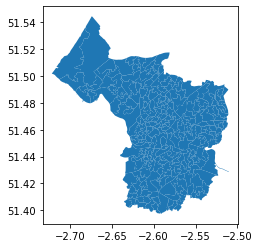

In [5]:
bristol_lsoal_gdf.plot()

## Part 2: Load in the Points of Interest (POI) from OSM
Alright, now we have the regions in the City of Bristol. We next want to get the POIs in the City. There are many ways to get the POIs, many of which have been introduced in the lecture (e.g., Yelp and Foursquare). Since we have already used OSM, why not playing with the POIs provided from OSM? 

As you may recall there are also many ways to load OSM data into Python. For example, you can readily use `pyrosm` to get the POIs in Bristol: 

```
from pyrosm import OSM, get_data
bristol = get_data("bristol")
osm = OSM(bristol)
bristol_pois = osm.get_pois()
```

However, some of you have encourtered issues of using this package. The main reason is that this package is sometimes out of date and its dependencies are not updated so that your system might have conflicts with it. The data extracted by this approach is sometimes also the very raw one without any preprocessing. 

The second way, which is recommended in this tutorial, is to directly download the data from https://download.geofabrik.de/, and then load it to Python:

In [6]:
## Option 2 (Recommended): directly download it from the website and load it into python
bristol_pois_file = "../../LabData/Lab3/gis_osm_pois_a_free_1.shp"
bristol_pois = gpd.read_file(bristol_pois_file)
bristol_pois.head()

,osm_id,code,fclass,name,geometry
0,3894324,2204,park,Portland Square,"POLYGON ((-2.58600 51.46103, -2.58600 51.46110..."
1,4297151,2204,park,Gainsborough Square,"POLYGON ((-2.56426 51.49027, -2.56422 51.49031..."
2,4309554,2008,town_hall,Bristol City Hall,"POLYGON ((-2.60242 51.45242, -2.60241 51.45244..."
3,4313536,2204,park,None,"POLYGON ((-2.57615 51.49791, -2.57609 51.49803..."
4,4313541,2204,park,Poets Park,"POLYGON ((-2.57429 51.49952, -2.57419 51.49972..."


As can be seen, there is a `fclass` column indicating the place type of the poi. We wil regard it as a token/term of a document, which will be explained in more detail later. 

Again, let's double check the crs of this data:

In [7]:
bristol_pois.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Let's also check the number of place types we have in this dataset: 

In [8]:
len(set(bristol_pois['fclass']))

104

Don't forget we can also use `.info()` to summary the basic info about such a dataset. For example, from the info below, we know that there are 5370 pois in this dataset. 

In [9]:
bristol_pois.info() # you can also use list(bristol_pois.columns) to check the list of the columns 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5370 entries, 0 to 5369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   osm_id    5370 non-null   object  
 1   code      5370 non-null   int64   
 2   fclass    5370 non-null   object  
 3   name      4567 non-null   object  
 4   geometry  5370 non-null   geometry
dtypes: geometry(1), int64(1), object(3)
memory usage: 209.9+ KB


And, we can also simply plot these pois:

<AxesSubplot:>

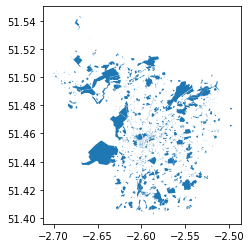

In [10]:
bristol_pois.plot()

## Part 3: Use WordCloud to Characterize Regions
For natural languages like the place types, a popular way to visulize it is to use a technique called WordCloud. It draws a "cloud" of words, where the position and size of the word is determined by its frequency in the document. In Python, we can use the package `wordcloud` to implement it. To do it, we need a document that contains words/tokens. 

However, what is the document in our case study here? 

There can be many ways and you are encouraged to be creative in answering this question. One way we will experiment here is to regard the whole City of Bristol as a document. Its words/tokens are those place types whose georeferenced POIs are within the City of Bristol. 

Let's next see how we implement it. We first need to convert the column `fclass` in `geodataframe` to a string (document). Then we can use the function `WordCloud` provided by the package `wordcloud` to build the cloud map. Note that the example showing below can be modified to other versions. You can check the [wordcloud gallaries](https://amueller.github.io/word_cloud/auto_examples/index.html) for some inspirations.  

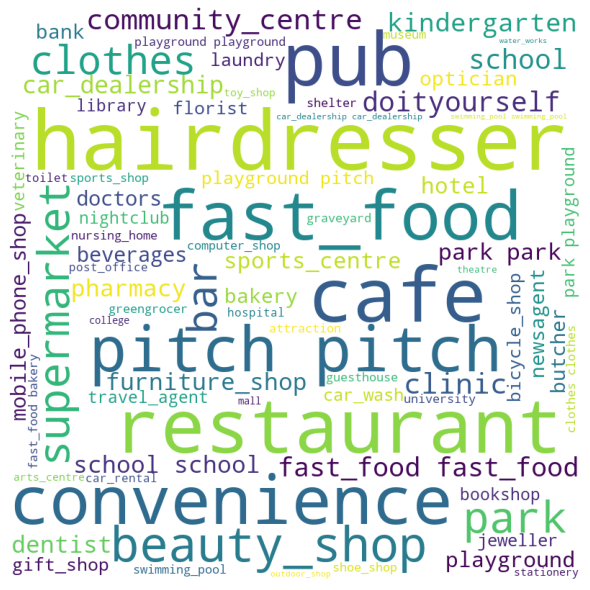

In [11]:
## use word cloud to visualize the frequency of poi types mentioned in Bristol 
# first you need to install the package of wordcloud 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

bristol_pois_doc = " ".join(list(bristol_pois['fclass']))

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(bristol_pois_doc)

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

So, we here regarded the whole City as a document. Can you try to implement it by regarding each LSOA11 region as the document? What other approaches can you think of? 

## Part 4: Preprocessing the data for GIR

After exploring some new techniques of visualizing regions using natural language processing techniques, next let's come back to the implemention of techniques we have learnt in the lecture. 

First, we would like to create a dataset where place types of POIs are assigned to each LSOA11 regions, as in later experiment, we will regard the LSOA11 regions as documents and place types will be the words/tokens. 

To do it, we can use `sjoin()`, which we have learnt before. Note the meaning of the parameters in the function, e.g., `how` and `op`. 

In [12]:
bristol_lsoal_pois = gpd.sjoin(bristol_lsoal_gdf, bristol_pois , how="left", op='intersects')
bristol_lsoal_pois.head()

/Users/gy22808/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,OBJECTID,LSOA11 Code,LSOA11 Name,LSOA11 Local name,MSOA11 Code,Ward code,Area square mteres,Perimeter (m),MI_PRINX,geo_shape,geo_point_2d,geom,index_right,osm_id,code,fclass,name
0,7,E01014612,Bristol 052B,Fortfield East,E02003063,E05001989,250084.34375,3010.960449,2,"{""coordinates"": [[[-2.5705649134167503, 51.408...","51.409649589944884,-2.566230812955203","POLYGON ((-2.57056 51.40811, -2.57048 51.40829...",5114.0,750955626,2253.0,swimming_pool,None
0,7,E01014612,Bristol 052B,Fortfield East,E02003063,E05001989,250084.34375,3010.960449,2,"{""coordinates"": [[[-2.5705649134167503, 51.408...","51.409649589944884,-2.566230812955203","POLYGON ((-2.57056 51.40811, -2.57048 51.40829...",5113.0,750955625,2253.0,swimming_pool,None
0,7,E01014612,Bristol 052B,Fortfield East,E02003063,E05001989,250084.34375,3010.960449,2,"{""coordinates"": [[[-2.5705649134167503, 51.408...","51.409649589944884,-2.566230812955203","POLYGON ((-2.57056 51.40811, -2.57048 51.40829...",4126.0,436088974,2205.0,playground,None
0,7,E01014612,Bristol 052B,Fortfield East,E02003063,E05001989,250084.34375,3010.960449,2,"{""coordinates"": [[[-2.5705649134167503, 51.408...","51.409649589944884,-2.566230812955203","POLYGON ((-2.57056 51.40811, -2.57048 51.40829...",1172.0,211278259,2204.0,park,Briery Leaze Road Open Space
1,8,E01014512,Bristol 016E,Somerville Road,E02003027,E05001975,178468.43750,3093.555908,152,"{""coordinates"": [[[-2.5836634052406393, 51.476...","51.47614221648566,-2.588736496528701","POLYGON ((-2.58366 51.47624, -2.58344 51.47609...",2008.0,272692036,2511.0,convenience,County Convenience Store


There are many columns from OSM that we might not use. Here we can remove them by using codes like:

In [13]:
drop_cols = ['index_right', 'osm_id', 'code', 'name']
bristol_lsoal_pois_dropped = bristol_lsoal_pois.drop(drop_cols, axis=1)
bristol_lsoal_pois_dropped.head()

,OBJECTID,LSOA11 Code,LSOA11 Name,LSOA11 Local name,MSOA11 Code,Ward code,Area square mteres,Perimeter (m),MI_PRINX,geo_shape,geo_point_2d,geom,fclass
0,7,E01014612,Bristol 052B,Fortfield East,E02003063,E05001989,250084.34375,3010.960449,2,"{""coordinates"": [[[-2.5705649134167503, 51.408...","51.409649589944884,-2.566230812955203","POLYGON ((-2.57056 51.40811, -2.57048 51.40829...",swimming_pool
0,7,E01014612,Bristol 052B,Fortfield East,E02003063,E05001989,250084.34375,3010.960449,2,"{""coordinates"": [[[-2.5705649134167503, 51.408...","51.409649589944884,-2.566230812955203","POLYGON ((-2.57056 51.40811, -2.57048 51.40829...",swimming_pool
0,7,E01014612,Bristol 052B,Fortfield East,E02003063,E05001989,250084.34375,3010.960449,2,"{""coordinates"": [[[-2.5705649134167503, 51.408...","51.409649589944884,-2.566230812955203","POLYGON ((-2.57056 51.40811, -2.57048 51.40829...",playground
0,7,E01014612,Bristol 052B,Fortfield East,E02003063,E05001989,250084.34375,3010.960449,2,"{""coordinates"": [[[-2.5705649134167503, 51.408...","51.409649589944884,-2.566230812955203","POLYGON ((-2.57056 51.40811, -2.57048 51.40829...",park
1,8,E01014512,Bristol 016E,Somerville Road,E02003027,E05001975,178468.43750,3093.555908,152,"{""coordinates"": [[[-2.5836634052406393, 51.476...","51.47614221648566,-2.588736496528701","POLYGON ((-2.58366 51.47624, -2.58344 51.47609...",convenience


There are still many things we need to process before this data can be used for our later study. One thing is that the column `fclass` might not be recorded as a `str` (natural language based string) as we expect. To ensure it is, we can use the code:

In [15]:
bristol_lsoal_pois_dropped['fclass'] = bristol_lsoal_pois_dropped['fclass'].astype('str') 
bristol_lsoal_pois_dropped.head()

,OBJECTID,LSOA11 Code,LSOA11 Name,LSOA11 Local name,MSOA11 Code,Ward code,Area square mteres,Perimeter (m),MI_PRINX,geo_shape,geo_point_2d,geom,fclass
0,7,E01014612,Bristol 052B,Fortfield East,E02003063,E05001989,250084.34375,3010.960449,2,"{""coordinates"": [[[-2.5705649134167503, 51.408...","51.409649589944884,-2.566230812955203","POLYGON ((-2.57056 51.40811, -2.57048 51.40829...",swimming_pool
0,7,E01014612,Bristol 052B,Fortfield East,E02003063,E05001989,250084.34375,3010.960449,2,"{""coordinates"": [[[-2.5705649134167503, 51.408...","51.409649589944884,-2.566230812955203","POLYGON ((-2.57056 51.40811, -2.57048 51.40829...",swimming_pool
0,7,E01014612,Bristol 052B,Fortfield East,E02003063,E05001989,250084.34375,3010.960449,2,"{""coordinates"": [[[-2.5705649134167503, 51.408...","51.409649589944884,-2.566230812955203","POLYGON ((-2.57056 51.40811, -2.57048 51.40829...",playground
0,7,E01014612,Bristol 052B,Fortfield East,E02003063,E05001989,250084.34375,3010.960449,2,"{""coordinates"": [[[-2.5705649134167503, 51.408...","51.409649589944884,-2.566230812955203","POLYGON ((-2.57056 51.40811, -2.57048 51.40829...",park
1,8,E01014512,Bristol 016E,Somerville Road,E02003027,E05001975,178468.43750,3093.555908,152,"{""coordinates"": [[[-2.5836634052406393, 51.476...","51.47614221648566,-2.588736496528701","POLYGON ((-2.58366 51.47624, -2.58344 51.47609...",convenience


More importantly, we need to group the place types (words/terms) to LSOA11 regions (documents). To do so, we can use the `groupby()` function provided in `pandas`. Here is how it looks like:

In [16]:
bristol_lsoal_pois_dropped.groupby('LSOA11 Code')['fclass'].apply(list)

LSOA11 Code
E01014485    [stationery, newsagent, school, pub, school, p...
E01014486    [fast_food, furniture_shop, butcher, newsagent...
E01014487    [furniture_shop, cafe, clinic, gift_shop, fast...
E01014488    [school, pitch, playground, convenience, schoo...
E01014489    [butcher, convenience, convenience, cafe, supe...
                                   ...                        
E01033364    [park, park, playground, park, fast_food, comm...
E01033366    [community_centre, park, convenience, playgrou...
E01033367    [restaurant, clothes, hairdresser, clothes, pu...
E01033369    [playground, car_dealership, playground, conve...
E01033370    [college, pub, restaurant, pitch, school, pitc...
Name: fclass, Length: 263, dtype: object

Once we have the grouped dataframe, we want to join it back to the `bristol_lsoal_gdf` dataframe. Here we can use a general `join()`:

In [17]:
bristol_lsoal_poi_full = bristol_lsoal_gdf.join(bristol_lsoal_pois_dropped.groupby('LSOA11 Code')['fclass'].apply(list), on='LSOA11 Code')
bristol_lsoal_poi_full.head()

,OBJECTID,LSOA11 Code,LSOA11 Name,LSOA11 Local name,MSOA11 Code,Ward code,Area square mteres,Perimeter (m),MI_PRINX,geo_shape,geo_point_2d,geom,fclass
0,7,E01014612,Bristol 052B,Fortfield East,E02003063,E05001989,250084.343750,3010.960449,2,"{""coordinates"": [[[-2.5705649134167503, 51.408...","51.409649589944884,-2.566230812955203","POLYGON ((-2.57056 51.40811, -2.57048 51.40829...","[swimming_pool, swimming_pool, playground, park]"
1,8,E01014512,Bristol 016E,Somerville Road,E02003027,E05001975,178468.437500,3093.555908,152,"{""coordinates"": [[[-2.5836634052406393, 51.476...","51.47614221648566,-2.588736496528701","POLYGON ((-2.58366 51.47624, -2.58344 51.47609...","[convenience, convenience, nursing_home, colle..."
2,18,E01014618,Bristol 011C,Henleaze North,E02003022,E05001990,324102.562500,4205.579590,921,"{""coordinates"": [[[-2.610432616527603, 51.4856...","51.489587737185744,-2.606558179420023","POLYGON ((-2.61043 51.48565, -2.61012 51.48600...","[kindergarten, community_centre, kindergarten,..."
3,36,E01014576,Bristol 019D,Rose Green,E02003030,E05001984,469484.093750,3586.286133,976,"{""coordinates"": [[[-2.5511455096576006, 51.463...","51.46845752679203,-2.5464321087549955","POLYGON ((-2.55115 51.46378, -2.55102 51.46396...","[sports_shop, beauty_shop, convenience, fast_f..."
4,24,E01033370,Bristol 054E,Redcliffe South,E02006887,E05001995,126227.867188,2103.395020,19,"{""coordinates"": [[[-2.5911512584061063, 51.445...","51.44681337159509,-2.5874479497333067","POLYGON ((-2.59115 51.44567, -2.59098 51.44604...","[college, pub, restaurant, pitch, school, pitc..."


We can also save the data as a `pickle` for future use by applying the following code. `pickle` is a module in python that convert python object into a byte stream (called "Pickling"), and vice verse (called "unpickling"). 

In [52]:
bristol_lsoal_poi_full.to_pickle("./bristol_lsoal_poi_full.pkl")

## Part 5: Compute TF-IDF
After the preprocessing, now let's apply some techniques in IR on these unstructured geo-text (i.e., poi's place types for regions). There are many things we can do here. The first thing we want is to find the most representative place types for the region, in analogy to finding the representative words in a document. So, we can use the TF-IDF we discussed in the lecture to do so. 

Before computing TF-IDF, we need to have a vocabulary. Here we simply call it a `wordSet`, which includes all the unique terms used in the document:

In [18]:
wordSet = set()
for index, row in bristol_lsoal_poi_full.iterrows():  
    wordSet = wordSet.union(set(row['fclass']))

In [19]:
wordSet

{'archaeological',
 'arts_centre',
 'artwork',
 'attraction',
 'bakery',
 'bank',
 'bar',
 'beauty_shop',
 'beverages',
 'bicycle_shop',
 'bookshop',
 'butcher',
 'cafe',
 'camp_site',
 'car_dealership',
 'car_rental',
 'car_wash',
 'caravan_site',
 'castle',
 'chemist',
 'cinema',
 'clinic',
 'clothes',
 'college',
 'comms_tower',
 'community_centre',
 'computer_shop',
 'convenience',
 'courthouse',
 'dentist',
 'department_store',
 'doctors',
 'doityourself',
 'fast_food',
 'fire_station',
 'florist',
 'food_court',
 'fountain',
 'furniture_shop',
 'garden_centre',
 'gift_shop',
 'golf_course',
 'graveyard',
 'greengrocer',
 'guesthouse',
 'hairdresser',
 'hospital',
 'hostel',
 'hotel',
 'jeweller',
 'kindergarten',
 'laundry',
 'library',
 'mall',
 'market_place',
 'memorial',
 'mobile_phone_shop',
 'monument',
 'museum',
 'nan',
 'newsagent',
 'nightclub',
 'nursing_home',
 'observation_tower',
 'optician',
 'outdoor_shop',
 'park',
 'pharmacy',
 'picnic_site',
 'pitch',
 'playgro

Once we have the vocabulary, next we will see how frequently each word/token in the vacabulary occurred in each of my document: 

In [20]:
docDic = {}
for index, row in bristol_lsoal_poi_full.iterrows():   
    doc = row['fclass']
    wordDict = dict.fromkeys(wordSet, 0) 
    for word in doc:
        wordDict[word]+=1
    docDic[row['LSOA11 Code']] = wordDict

In [21]:
docDic

{'E01014612': {'clothes': 0,
  'butcher': 0,
  'dentist': 0,
  'recycling': 0,
  'sports_shop': 0,
  'furniture_shop': 0,
  'bicycle_shop': 0,
  'recycling_glass': 0,
  'hospital': 0,
  'track': 0,
  'chemist': 0,
  'garden_centre': 0,
  'veterinary': 0,
  'beauty_shop': 0,
  'car_wash': 0,
  'supermarket': 0,
  'tower': 0,
  'outdoor_shop': 0,
  'playground': 1,
  'college': 0,
  'fountain': 0,
  'car_rental': 0,
  'park': 1,
  'wastewater_plant': 0,
  'swimming_pool': 2,
  'beverages': 0,
  'hostel': 0,
  'nursing_home': 0,
  'mobile_phone_shop': 0,
  'memorial': 0,
  'nan': 0,
  'newsagent': 0,
  'artwork': 0,
  'jeweller': 0,
  'cafe': 0,
  'water_works': 0,
  'ruins': 0,
  'arts_centre': 0,
  'market_place': 0,
  'university': 0,
  'kindergarten': 0,
  'monument': 0,
  'convenience': 0,
  'community_centre': 0,
  'guesthouse': 0,
  'mall': 0,
  'camp_site': 0,
  'greengrocer': 0,
  'bank': 0,
  'graveyard': 0,
  'shoe_shop': 0,
  'car_dealership': 0,
  'gift_shop': 0,
  'stadium':

`docDic` here is a dictionary of dictionary. The inner dictionary is the frequency of each word occurred in the document. The outer dictionary is about different documents. We next can convert such a dictionary into a `dataframe`:

In [22]:
doc2wordMatrix = pd.DataFrame.from_dict(docDic, orient='index').rename_axis('LSOA11 Code').reset_index()

In [23]:
doc2wordMatrix.head()

,LSOA11 Code,clothes,butcher,dentist,recycling,sports_shop,furniture_shop,bicycle_shop,recycling_glass,hospital,...,caravan_site,doityourself,toilet,sports_centre,laundry,courthouse,town_hall,toy_shop,theatre,doctors
0,E01014612,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,E01014512,0,1,1,0,0,0,0,0,0,...,0,3,0,3,0,0,0,0,1,0
2,E01014618,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,E01014576,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,E01033370,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Note here such a data sometimes is referred as a document matrix, where each row is a document, and each column is a word/token from the vocabulary. The value in the matrix represents the frequency of the word/token in the correspoding document. For example, we can see that place types `car_dealership` and `college` both occurred once in the document with LSOA11 code "E01014512" (remember that it is actually a region in our example). 

Now, we can start computing the term frequency-inverse document frequency (TF-IDF), which will be used later for us to determine the relevance ranking of documents in relation to a query. The functions are written below. We first compute TF, and then IDF. Multiplying both, we will have TF-IDF. Please read it first and try to think if you can understand it:

In [24]:
## Compute term frequency (TF)
def computeTF(wordDict):
    tfDict = {}
    bowCount = 0
    for word, count in wordDict.items():
        if count >0:
            bowCount +=1
    for word, count in wordDict.items():
        tfDict[word] = count/float(bowCount)
    return tfDict

We can use the `computeTF()` function on one example document (region with code 'E01014612'). From the result, you can see the frequency of "swimming_pool" in this region is 0.666666666, frequency of "park" is 0.3333333, and the frequency of seeing "playground" is also 0.33333333. 

In [25]:
computeTF(docDic['E01014612'])

{'clothes': 0.0,
 'butcher': 0.0,
 'dentist': 0.0,
 'recycling': 0.0,
 'sports_shop': 0.0,
 'furniture_shop': 0.0,
 'bicycle_shop': 0.0,
 'recycling_glass': 0.0,
 'hospital': 0.0,
 'track': 0.0,
 'chemist': 0.0,
 'garden_centre': 0.0,
 'veterinary': 0.0,
 'beauty_shop': 0.0,
 'car_wash': 0.0,
 'supermarket': 0.0,
 'tower': 0.0,
 'outdoor_shop': 0.0,
 'playground': 0.3333333333333333,
 'college': 0.0,
 'fountain': 0.0,
 'car_rental': 0.0,
 'park': 0.3333333333333333,
 'wastewater_plant': 0.0,
 'swimming_pool': 0.6666666666666666,
 'beverages': 0.0,
 'hostel': 0.0,
 'nursing_home': 0.0,
 'mobile_phone_shop': 0.0,
 'memorial': 0.0,
 'nan': 0.0,
 'newsagent': 0.0,
 'artwork': 0.0,
 'jeweller': 0.0,
 'cafe': 0.0,
 'water_works': 0.0,
 'ruins': 0.0,
 'arts_centre': 0.0,
 'market_place': 0.0,
 'university': 0.0,
 'kindergarten': 0.0,
 'monument': 0.0,
 'convenience': 0.0,
 'community_centre': 0.0,
 'guesthouse': 0.0,
 'mall': 0.0,
 'camp_site': 0.0,
 'greengrocer': 0.0,
 'bank': 0.0,
 'gravey

Next, we have the function `computeIDF()` to compute inverse document frequency. Note the use of `math.log10()` in the last step is to avoid the situation where the number of documents N is too large making `N/float(count)` become too large as well. This logarithm is to scale the inversed document frequency to a relatively small value (e.g., a dampen effect).   

In [26]:
## Compute inverse document frequency (IDF)
def computeIDF(docDic):
    import math
    idfDict = {}
    N = len(docDic)
    
    idfDict = dict.fromkeys(wordSet, 0)
    for doc, wordDic in docDic.items():
        for word, count in wordDic.items():
            if count > 0:
                idfDict[word] += 1
    
    for word, count in idfDict.items():  ## this count is the number of document containing the word 
        idfDict[word] = math.log10(N / float(count))
        
    return idfDict    

With this function, we can then input all the documents (represented using the `docDoc` variable) to it so as to obtain the inverse document frequency (idfs), which is also represented as a dictionary. The keys of the dictionary are the words/tokens from the vocabulary. The values are the computed IDF. 

In [27]:
idfs = computeIDF(docDic)

In [28]:
idfs

{'clothes': 0.8401721518729477,
 'butcher': 1.0049824005189398,
 'dentist': 0.7297596684612442,
 'recycling': 2.419955748489758,
 'sports_shop': 1.1189257528257768,
 'furniture_shop': 0.8636532477224705,
 'bicycle_shop': 1.058227912472165,
 'recycling_glass': 1.9428344937700954,
 'hospital': 1.189506827111484,
 'track': 1.306012396182921,
 'chemist': 2.1189257528257768,
 'garden_centre': 1.720985744153739,
 'veterinary': 1.058227912472165,
 'beauty_shop': 0.5811066577525026,
 'car_wash': 0.9727977171475386,
 'supermarket': 0.5168657614978143,
 'tower': 1.720985744153739,
 'outdoor_shop': 1.574857708475501,
 'playground': 0.34440878709722716,
 'college': 1.215835765833833,
 'fountain': 2.419955748489758,
 'car_rental': 1.306012396182921,
 'park': 0.17198248212795123,
 'wastewater_plant': 2.1189257528257768,
 'swimming_pool': 1.058227912472165,
 'beverages': 0.8517540244227628,
 'hostel': 1.9428344937700954,
 'nursing_home': 1.2738277128115199,
 'mobile_phone_shop': 1.141202147536929,
 '

By multiplying `tf` and `idf`, we can finally have the TF-IDF using the function:

In [29]:
def computeTFIDF(tf, idfs):
    tfidf = {}
    for word, freq in tf.items():
        tfidf[word] = freq*idfs[word]
    return tfidf

Here is an example on how we use the function: 

In [30]:
tfidfDic = {}
for doc, wordDic in docDic.items():
    doc_tfidf = computeTFIDF(wordDic, idfs)
    tfidfDic[doc] = doc_tfidf

In [31]:
tfidfDic

{'E01014612': {'clothes': 0.0,
  'butcher': 0.0,
  'dentist': 0.0,
  'recycling': 0.0,
  'sports_shop': 0.0,
  'furniture_shop': 0.0,
  'bicycle_shop': 0.0,
  'recycling_glass': 0.0,
  'hospital': 0.0,
  'track': 0.0,
  'chemist': 0.0,
  'garden_centre': 0.0,
  'veterinary': 0.0,
  'beauty_shop': 0.0,
  'car_wash': 0.0,
  'supermarket': 0.0,
  'tower': 0.0,
  'outdoor_shop': 0.0,
  'playground': 0.34440878709722716,
  'college': 0.0,
  'fountain': 0.0,
  'car_rental': 0.0,
  'park': 0.17198248212795123,
  'wastewater_plant': 0.0,
  'swimming_pool': 2.11645582494433,
  'beverages': 0.0,
  'hostel': 0.0,
  'nursing_home': 0.0,
  'mobile_phone_shop': 0.0,
  'memorial': 0.0,
  'nan': 0.0,
  'newsagent': 0.0,
  'artwork': 0.0,
  'jeweller': 0.0,
  'cafe': 0.0,
  'water_works': 0.0,
  'ruins': 0.0,
  'arts_centre': 0.0,
  'market_place': 0.0,
  'university': 0.0,
  'kindergarten': 0.0,
  'monument': 0.0,
  'convenience': 0.0,
  'community_centre': 0.0,
  'guesthouse': 0.0,
  'mall': 0.0,
  '

`tfidfDic` is a dictionary of dictionary. The inner is a dictionary of words with their tfidf scores, and the outer is the document dictionary. 

Again, we can convert the tfidf dictionary to a `dataframe` by using code:

In [32]:
doc2wordTFIDFMatrix = pd.DataFrame.from_dict(tfidfDic, orient='index').rename_axis('LSOA11 Code').reset_index()
doc2wordTFIDFMatrix.head()

,LSOA11 Code,clothes,butcher,dentist,recycling,sports_shop,furniture_shop,bicycle_shop,recycling_glass,hospital,...,caravan_site,doityourself,toilet,sports_centre,laundry,courthouse,town_hall,toy_shop,theatre,doctors
0,E01014612,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
1,E01014512,0.0,1.004982,0.72976,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,2.359462,0.0,2.329509,0.0,0.0,0.0,0.000000,1.378563,0.0
2,E01014618,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
3,E01014576,0.0,0.000000,0.00000,0.0,1.118926,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.378563,0.000000,0.0
4,E01033370,0.0,0.000000,0.00000,0.0,0.000000,0.863653,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0


Different from `doc2wordMatrix` where the term frequency is recorded, this `doc2wordTFIDFMatrix` records the TF-IDF values. As we have discussed in the lecture, the TF-IDF can better represent the uniqueness of terms in a document. 

So far, we have mannually implemented the TF-IDF computation. In fact, we can also achieve the same using existing packages:

In [33]:
## automatically compute the IF-IDF using packages sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

/Users/gy22808/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


`TfidfVectorizer()` here is to initialize a Tfidf vector, which we will use in the next steps to fit the TF-IDF scores from the documents. Before that, we also have to prepare a list of string: `docList` as the input for the next step:

In [34]:
docList = list(bristol_lsoal_poi_full['fclass'].apply(' '.join))
docList

['swimming_pool swimming_pool playground park',
 'convenience convenience nursing_home college hairdresser computer_shop fast_food restaurant doityourself car_wash convenience restaurant sports_centre clinic hairdresser sports_centre doityourself car_dealership restaurant dentist kindergarten community_centre cafe doityourself butcher theatre sports_centre',
 'kindergarten community_centre kindergarten convenience hairdresser fast_food playground park park convenience cafe fast_food fast_food hairdresser beauty_shop',
 'sports_shop beauty_shop convenience fast_food pub car_dealership playground pitch pitch toy_shop playground',
 'college pub restaurant pitch school pitch park car_dealership pitch playground furniture_shop hotel pub hotel kindergarten convenience fast_food fast_food',
 'convenience beauty_shop fast_food pharmacy hairdresser pub fast_food park doityourself car_dealership doityourself car_wash doityourself',
 'bakery pub pub pub restaurant sports_centre gift_shop pub conv

Then, we can use the `fit_transform()` function provided by `TfidfVectorizer` to get the `tfidf` scores: 

In [35]:
tfidf_response = tfidf.fit_transform(docList)

We can also convert the result of a specific document into a `dataframe` as well: 

In [36]:
tfidf_pd = pd.DataFrame(tfidf_response[0].T.todense(), index=tfidf.get_feature_names(), columns=["TF-IDF"])

/Users/gy22808/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
tfidf_pd

,TF-IDF
archaeological,0.0
arts_centre,0.0
artwork,0.0
attraction,0.0
bakery,0.0
...,...
veterinary,0.0
video_shop,0.0
wastewater_plant,0.0
water_tower,0.0


As can be seen here, since the list of words is long, many of the rows are not showing here. A trick to show the full table with all rows being listed is to use the code below:

In [38]:
pd.set_option('display.max_rows', None)
tfidf_pd

,TF-IDF
archaeological,0.000000
arts_centre,0.000000
artwork,0.000000
attraction,0.000000
bakery,0.000000
bank,0.000000
bar,0.000000
beauty_shop,0.000000
beverages,0.000000
bicycle_shop,0.000000


We can also order the `tfidf_pd` and only show the top 25 (or other numbers as you wish) records. As we have learnt from the lecture, the greater the TF-IDF, the more relevant/unique the word is to characterize the document. 

In [39]:
tfidf_pd = tfidf_pd.sort_values('TF-IDF', ascending=False)
tfidf_pd.head(25)

,TF-IDF
swimming_pool,0.948583
playground,0.249640
park,0.194603
recycling_metal,0.000000
recycling,0.000000
public_building,0.000000
pub,0.000000
prison,0.000000
post_office,0.000000
police,0.000000


## Part 6: Relevance Ranking
With TF-IDF for each word in the document, we can then compute the relevance of a query in respect to the candidate documents. A real-world scenaria can be like this: a user might want to find similar regions that have POIs with place types including "park" and "car dealership" (this is the query). What we can do is to compare the vector of query with the vector of each document, and rank their relevances. The top documents then can be selected to responde to users' query. The vector here is exactly the TF-IDF vector we have just computed (like the `tfidf_pd`). 

For the query, we regard it as a single document. Its TF-IDF vector is computed using the same way as what we have done (namely, we can directly multiple the IDF (same as before) with the TF of this specific query document). Below are the codes.

First, we get the term frequency dictionary of the query document:

In [40]:
## rank the relevance score of a query to the documents (region)
query = ["park", "car_dealership"]
# get the vector of the query (same to what we have done before)
query_wordDict = dict.fromkeys(wordSet, 0) 
for word in query:
    query_wordDict[word]+=1
query_wordDict

{'clothes': 0,
 'butcher': 0,
 'dentist': 0,
 'recycling': 0,
 'sports_shop': 0,
 'furniture_shop': 0,
 'bicycle_shop': 0,
 'recycling_glass': 0,
 'hospital': 0,
 'track': 0,
 'chemist': 0,
 'garden_centre': 0,
 'veterinary': 0,
 'beauty_shop': 0,
 'car_wash': 0,
 'supermarket': 0,
 'tower': 0,
 'outdoor_shop': 0,
 'playground': 0,
 'college': 0,
 'fountain': 0,
 'car_rental': 0,
 'park': 1,
 'wastewater_plant': 0,
 'swimming_pool': 0,
 'beverages': 0,
 'hostel': 0,
 'nursing_home': 0,
 'mobile_phone_shop': 0,
 'memorial': 0,
 'nan': 0,
 'newsagent': 0,
 'artwork': 0,
 'jeweller': 0,
 'cafe': 0,
 'water_works': 0,
 'ruins': 0,
 'arts_centre': 0,
 'market_place': 0,
 'university': 0,
 'kindergarten': 0,
 'monument': 0,
 'convenience': 0,
 'community_centre': 0,
 'guesthouse': 0,
 'mall': 0,
 'camp_site': 0,
 'greengrocer': 0,
 'bank': 0,
 'graveyard': 0,
 'shoe_shop': 0,
 'car_dealership': 1,
 'gift_shop': 0,
 'stadium': 0,
 'hotel': 0,
 'bakery': 0,
 'restaurant': 0,
 'shelter': 0,
 'h

In [41]:
query_tf = computeTF(query_wordDict)
query_tf

{'clothes': 0.0,
 'butcher': 0.0,
 'dentist': 0.0,
 'recycling': 0.0,
 'sports_shop': 0.0,
 'furniture_shop': 0.0,
 'bicycle_shop': 0.0,
 'recycling_glass': 0.0,
 'hospital': 0.0,
 'track': 0.0,
 'chemist': 0.0,
 'garden_centre': 0.0,
 'veterinary': 0.0,
 'beauty_shop': 0.0,
 'car_wash': 0.0,
 'supermarket': 0.0,
 'tower': 0.0,
 'outdoor_shop': 0.0,
 'playground': 0.0,
 'college': 0.0,
 'fountain': 0.0,
 'car_rental': 0.0,
 'park': 0.5,
 'wastewater_plant': 0.0,
 'swimming_pool': 0.0,
 'beverages': 0.0,
 'hostel': 0.0,
 'nursing_home': 0.0,
 'mobile_phone_shop': 0.0,
 'memorial': 0.0,
 'nan': 0.0,
 'newsagent': 0.0,
 'artwork': 0.0,
 'jeweller': 0.0,
 'cafe': 0.0,
 'water_works': 0.0,
 'ruins': 0.0,
 'arts_centre': 0.0,
 'market_place': 0.0,
 'university': 0.0,
 'kindergarten': 0.0,
 'monument': 0.0,
 'convenience': 0.0,
 'community_centre': 0.0,
 'guesthouse': 0.0,
 'mall': 0.0,
 'camp_site': 0.0,
 'greengrocer': 0.0,
 'bank': 0.0,
 'graveyard': 0.0,
 'shoe_shop': 0.0,
 'car_dealershi

Then, we get the TF-IDF using the function `computeTFIDF()`:

In [42]:
# we often use the same idfs as the documents
query_idf = idfs
query_tfidf = computeTFIDF(query_tf, query_idf)
query_tfidf

{'clothes': 0.0,
 'butcher': 0.0,
 'dentist': 0.0,
 'recycling': 0.0,
 'sports_shop': 0.0,
 'furniture_shop': 0.0,
 'bicycle_shop': 0.0,
 'recycling_glass': 0.0,
 'hospital': 0.0,
 'track': 0.0,
 'chemist': 0.0,
 'garden_centre': 0.0,
 'veterinary': 0.0,
 'beauty_shop': 0.0,
 'car_wash': 0.0,
 'supermarket': 0.0,
 'tower': 0.0,
 'outdoor_shop': 0.0,
 'playground': 0.0,
 'college': 0.0,
 'fountain': 0.0,
 'car_rental': 0.0,
 'park': 0.08599124106397561,
 'wastewater_plant': 0.0,
 'swimming_pool': 0.0,
 'beverages': 0.0,
 'hostel': 0.0,
 'nursing_home': 0.0,
 'mobile_phone_shop': 0.0,
 'memorial': 0.0,
 'nan': 0.0,
 'newsagent': 0.0,
 'artwork': 0.0,
 'jeweller': 0.0,
 'cafe': 0.0,
 'water_works': 0.0,
 'ruins': 0.0,
 'arts_centre': 0.0,
 'market_place': 0.0,
 'university': 0.0,
 'kindergarten': 0.0,
 'monument': 0.0,
 'convenience': 0.0,
 'community_centre': 0.0,
 'guesthouse': 0.0,
 'mall': 0.0,
 'camp_site': 0.0,
 'greengrocer': 0.0,
 'bank': 0.0,
 'graveyard': 0.0,
 'shoe_shop': 0.0,

The dictionary can also be converted to a `dataframe`:

In [43]:
queryTFIDFMatrix = pd.DataFrame.from_dict(query_tfidf, orient='index').T
queryTFIDFMatrix

,clothes,butcher,dentist,recycling,sports_shop,furniture_shop,bicycle_shop,recycling_glass,hospital,track,...,caravan_site,doityourself,toilet,sports_centre,laundry,courthouse,town_hall,toy_shop,theatre,doctors
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, we can write a function to compute the similarity between the TF-IDF vectors of candicate documents (`doc_tfidf`) with the TF-IDF vector of the query document (`query_tfidf`), and rank it using codes like:

In [44]:
import numpy as np
from numpy.linalg import norm

def rankingTFIDF(query_tfidf, doc_tfidf):
    doc_cosine = []
    for index, row in doc_tfidf.iterrows():
        doc_tfidf_vec = row.to_numpy().flatten()[1:]
        query_tfidf_vec = query_tfidf.to_numpy().flatten()
        cosine = np.dot(doc_tfidf_vec,query_tfidf_vec)/norm(doc_tfidf_vec)*norm(query_tfidf_vec)
        doc_cosine.append([row[0], cosine])
    doc_cosine_df = pd.DataFrame(doc_cosine, columns=["LSOA11 Code", "Cosine Similarity"]) 
    doc_cosine_df = doc_cosine_df.sort_values(by=['Cosine Similarity'],ascending=False)
    return doc_cosine_df

To apply the function and only show the top 10 results: 

In [45]:
doc_cosine_df_test = rankingTFIDF(queryTFIDFMatrix, doc2wordTFIDFMatrix)
doc_cosine_df_test.iloc[0:9]

,LSOA11 Code,Cosine Similarity
203,E01014537,0.106043
22,E01014569,0.090785
207,E01014565,0.090718
51,E01014679,0.086994
121,E01014506,0.082671
72,E01014675,0.077745
147,E01014682,0.060071
116,E01033352,0.058472
47,E01014617,0.058310


To evaluate the results, we check the TF-IDF vector of the document who is ranked the top. We can find that this document (region) contains pois with types of "car dealership" and "park" as well (as what our query requests):

In [50]:
pd.set_option('display.max_columns', None)
doc2wordTFIDFMatrix.loc[doc2wordTFIDFMatrix['LSOA11 Code'] == "E01014537"]

,LSOA11 Code,clothes,butcher,dentist,recycling,sports_shop,furniture_shop,bicycle_shop,recycling_glass,hospital,track,chemist,garden_centre,veterinary,beauty_shop,car_wash,supermarket,tower,outdoor_shop,playground,college,fountain,car_rental,park,wastewater_plant,swimming_pool,beverages,hostel,nursing_home,mobile_phone_shop,memorial,nan,newsagent,artwork,jeweller,cafe,water_works,ruins,arts_centre,market_place,university,kindergarten,monument,convenience,community_centre,guesthouse,mall,camp_site,greengrocer,bank,graveyard,shoe_shop,car_dealership,gift_shop,stadium,hotel,bakery,restaurant,shelter,hairdresser,post_office,public_building,department_store,comms_tower,fire_station,stationery,library,theme_park,castle,water_tower,picnic_site,tourist_info,golf_course,school,cinema,optician,prison,florist,food_court,travel_agent,attraction,pub,fast_food,museum,video_shop,archaeological,observation_tower,pitch,recycling_metal,clinic,bar,computer_shop,bookshop,nightclub,police,pharmacy,caravan_site,doityourself,toilet,sports_centre,laundry,courthouse,town_hall,toy_shop,theatre,doctors
203,E01014537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.258588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.245519,0.0,0.0,0.0,0.0,0.0,0.0,0.286417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.399695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.703952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Great that you have followed the instructions till here. Note that it is just an example to show you how some introduced techniques in the lecture can be implemented in Python. Hope it is interesting and have inspired you on your own projects. Also note that the dataset we are using - place types of POIs - is relatively clean. In most geo-text analysis, you might need to use a lot natural language preprocessing such as stemming, lemmatisation, punctuation, etc. Don't forget that `spaCy` can help you on it (Lab 2). 